# Applying a Markov chain model to Galton's height data

## Markov chain model

#### Initial conditions and transitions

The Markov chain exists in discrete time $\{0, 1, 2,...\}$, representing generations; and continuous space $\mathbb{R}$, representing polygenic scores.


Let all $Z$ be independent and identically distributed (i.i.d.) as $\mathcal{N}(0, 1)$.

Define the initial condition:

$X_0 = \sigma_0 Z$

Define the one-step relationship between past and present states:

$X_n = \tilde{\mu}_n + \epsilon$

Such that:

$\tilde{\mu}_n = rX_{n-1}$

$\epsilon = \tilde{\sigma}_n Z$

$\tilde{\sigma}_n = r_s \sigma_{n-1}$

Rewriting the relationship:

$X_n = rX_{n-1} + r_s \sigma_{n-1}Z$

#### The random state for any generation $n$. 

It can be shown by induction and the theorem of the sum of independent normal distributions that:

$X_n = \sigma_n Z$

Additionally, for $n > 0$ and $Z_a$, $Z_b$ independent:


$X_n = r\sigma_{n-1}Z_a + r_s\sigma_{n-1}Z_b$

#### The variance for any generation $n$.

It follows immediately that $\sigma_n^2$ has the following one-step relationship:

$\sigma_n^2 = \sigma_{n-1}^2(r^2+r_s^2)$

By induction, $\sigma_n^2$ can also be stated in terms of the initial variance:

$\sigma_n^2 = \sigma_{0}^2(r^2+r_s^2)^n$

#### Properties

$X_n|X_{n-1} \sim \mathcal{N}(\tilde{\mu}_n, \tilde{\sigma}_n^2)$


$\mathrm{Cov}(X_n, X_{n-1}) = r \sigma_{n-1}^2$

$\mathrm{Corr}(X_n, X_{n-1}) = r \frac{\sigma_{n-1}}{\sigma_n}$



#### Stable population variance

Let a stable population variance be defined as follows:

$\sigma_n^2 = \sigma_{n-1}^2$

The following are a few important properties that occur under stable population variance:

$r^2+r_s^2 = 1$

$\mathrm{Corr}(X_n, X_{n-1}) = r$

For an aribrary state $i$:

$\sigma_i^2 = \sigma_{0}^2$ 

### Load and prepare data

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import pylab

In [2]:
df = pd.read_csv('galton_height.csv')

In [4]:
df

,Family,Father,Mother,Gender,Height,Kids
0,1,78.5,67.0,M,73.2,4
1,1,78.5,67.0,F,69.2,4
2,1,78.5,67.0,F,69.0,4
3,1,78.5,67.0,F,69.0,4
4,2,75.5,66.5,M,73.5,4
...,...,...,...,...,...,...
893,136A,68.5,65.0,M,68.5,8
894,136A,68.5,65.0,M,67.7,8
895,136A,68.5,65.0,F,64.0,8
896,136A,68.5,65.0,F,63.5,8


In [114]:
# Standard deviations of the father and mother heights

print(df.Father.std())
print(df.Mother.std())

2.4702558107108183
2.307025221001852


In [116]:
# Standard deviations of the male and female adult children heights

print(df.loc[df.Gender == 'M'].Height.std())
print(df.loc[df.Gender == 'F'].Height.std())

2.631594282686617
2.37031960294407


#### Separate samples by gender

That is, treat the father-son data separately from the mother-daughter data. There are ways to combine male and female heights, e.g. Tanner's method, but here we will simply separate them.

In [101]:
# Let the suffixes `b` and `g` represent boy and girl 
# (Male and female gets confused with mother and father)

dfb = df.loc[df.Gender == 'M'][['Father', 'Height']]
dfg = df.loc[df.Gender == 'F'][['Mother', 'Height']]

#### Standardize to the parent distribution

In [16]:
# Let the suffix `s` indicate 'standardized'

# We also standardize the adult children to the expecation and variance of the parents

dfbs = (dfb - dfb.Father.mean()) / dfb.Father.std()
dfgs = (dfg - dfg.Mother.mean()) / dfg.Mother.std()

# Verify the Markov chain model in the one-step Galton data

### Verify normality of mother and father distributions

We would like to verify the initial condition for both the father and mother populations:

$X_0 = \sigma_0 Z$

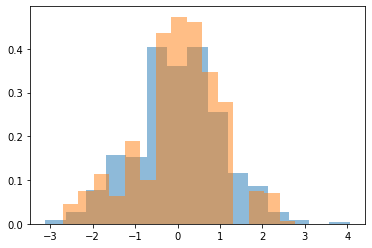

In [163]:
plt.hist(dfbs.Father, alpha=0.5, bins=15, density=True)
plt.hist(dfgs.Mother, alpha=0.5, bins=15, density=True);

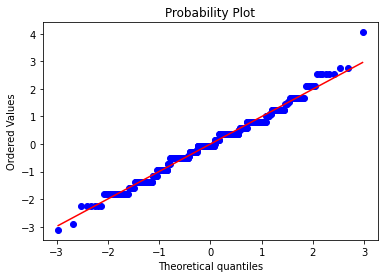

In [70]:
stats.probplot(dfbs.Father, dist="norm", fit=False, plot=pylab);

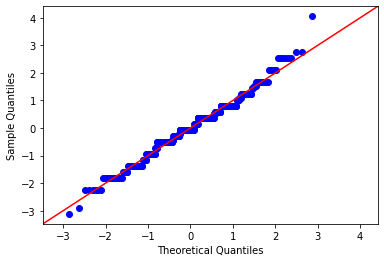

In [18]:
sm.qqplot(dfbs.Father, line ='45');

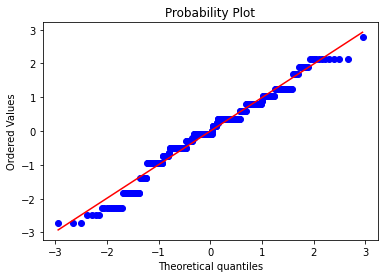

In [71]:
stats.probplot(dfgs.Mother, dist="norm", fit=False, plot=pylab);

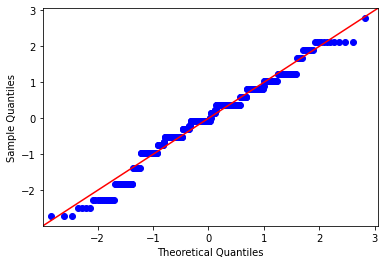

In [22]:
sm.qqplot(dfgs.Mother, line ='45');

Normality assumption looks alright.

### Verify the expectation of $X_{n}$

We would like to verify that:
    
$\mathrm{E}(X_n) = 0$

In [85]:
dfbs.Height.mean()

0.0263682727955682

In [86]:
dfgs.Height.mean()

-0.02606626673986234

The expecation of the adult-children heights are both within 0.03 parent-population standard deviations from zero. 

### Estimate expectation regression coefficient $r$


$\mathrm{E}(X_n|X_{n-1}) = rX_{n-1}$

$X_n = rX_{n-1} + \epsilon$


This has the same form as the linear regression model where $b$ can be estimated by minimising the sum of the squared errors.

$\mathrm{E}(Y|X) = bX$

$Y = bX + \epsilon$

This means we can estimate $r$ through the least-squares approach. 


#### Show scatterplots of linear relationship

(465, 2)


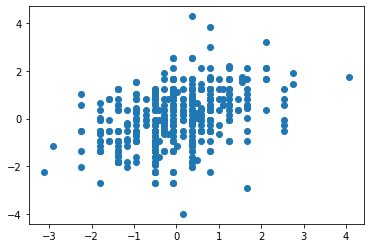

In [110]:
plt.scatter(dfbs.Father, dfbs.Height);
print(dfbs.shape)

(433, 2)


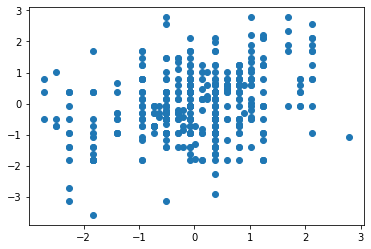

In [111]:
plt.scatter(dfgs.Mother, dfgs.Height);
print(dfgs.shape)

#### Estimate $r$ from ordinary least squares

In [28]:
from sklearn.linear_model import LinearRegression

In [190]:
# `fit_intercept=False` means we assume E(X_n) = 0 as shown above

lmb = LinearRegression(fit_intercept=False)
lmb.fit(dfbs.Father.to_numpy().reshape(-1, 1), 
       dfbs.Height.to_numpy())

print('Least squares estimate of r for father-sons:', lmb.coef_[0], sep='\n')

Least squares estimate of r for father-sons:
0.4477479176030256


In [191]:
lmg = LinearRegression(fit_intercept=False)
lmg.fit(dfgs.Mother.to_numpy().reshape(-1, 1), 
       dfgs.Height.to_numpy())

print('Least squares estimate of r for mother-daughters:', lmg.coef_[0], sep='\n')

Least squares estimate of r for mother-daughters:
0.32655230653888556


In [194]:
# Get the correlation coefficient in two ways

print(np.sqrt(lmb.score(dfbs.Father.to_numpy().reshape(-1, 1), 
       dfbs.Height.to_numpy())))

print(stats.pearsonr(dfbs.Father, dfbs.Height))

0.3906367327317112
(0.3913173581417901, 1.8240160816397863e-18)


In [195]:
print(np.sqrt(lmg.score(dfgs.Mother.to_numpy().reshape(-1, 1), 
       dfgs.Height.to_numpy())))

print(stats.pearsonr(dfgs.Mother, dfgs.Height))

0.31269504705987256
(0.313698353531347, 2.4209888639419706e-11)


#### Estimate $r$ from model

$\mathrm{Cov}(X_n, X_{n-1}) = r \sigma_{n-1}^2$

$\mathrm{Corr}(X_n, X_{n-1}) = r \frac{\sigma_{n-1}}{\sigma_n}$



In [173]:
rb = (np.cov(dfbs.Father, dfbs.Height) / dfbs.Father.var())[0][1]

In [174]:
rg = (np.cov(dfgs.Mother, dfgs.Height) / dfgs.Mother.var())[0][1]

In [176]:
print(rb)
print(rg)

0.44774791760302557
0.3265523065388858


### Verify normality of $\epsilon$

We would like to verify: 

$\epsilon = r_s \sigma_{n-1}Z$


Recall that the Father and Mother samples were the 0th generation, and were standardized to have expectation 0 and variance 1.

$\sigma_{n-1} = \sigma_0 = 1$

Then we need to verify:

$\epsilon = r_s Z$

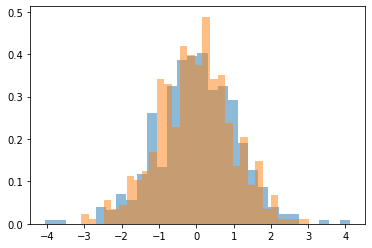

In [164]:
plt.hist(eb, alpha=0.5, bins=30, density=True)
plt.hist(eg, alpha=0.5, bins=30, density=True);

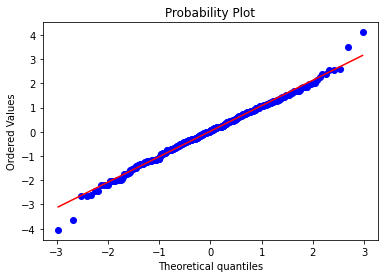

In [144]:
stats.probplot(eb, dist="norm", fit=False, plot=pylab);

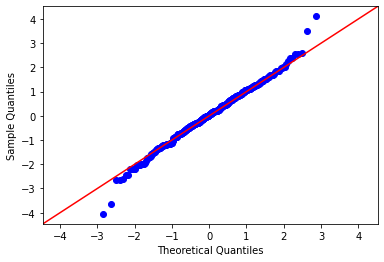

In [145]:
sm.qqplot(eb, line ='45');

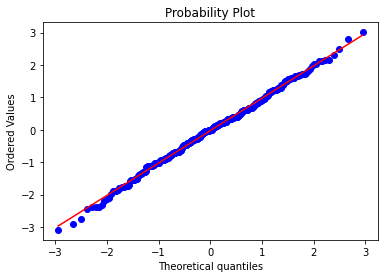

In [146]:
stats.probplot(eg, dist="norm", fit=False, plot=pylab);

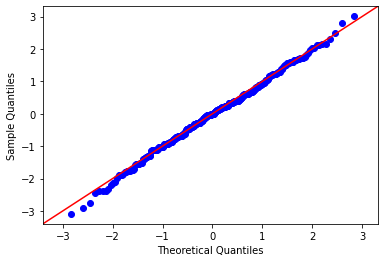

In [147]:
sm.qqplot(eg, line ='45');

Normality assumption looks alright other than a few outliers.

### Verify the expectation of $\epsilon$

For the Markov model:

$\epsilon = X_n - rX_{n-1} $

In linear regression:

$\epsilon = Y - bX$


$\mathrm{E}(\epsilon) = 0 $

In [97]:
# Let `e` indicate epsilon with the same suffix convention as earlier

eb = (dfbs.Height - rb*dfbs.Father).to_numpy()

print(eb.mean())

0.026368272795568883


In [98]:
eg = (dfgs.Height - rb*dfgs.Mother).to_numpy()

print(eg.mean())

-0.026066266739861847


The expecation of the adult-children residuals are both within 0.03 parent-population standard deviations from zero. 

### Estimate standard deviation regression coefficient $r_s$

Because $\sigma_0 = 1$ and we have verified that $\epsilon = r_s Z$, we have:

$r_s = \sqrt{\mathrm{Var}(\epsilon)}$

In [177]:
rsb = eb.std()
rsg = eg.std()

In [179]:
print(rsb)
print(rsg)

1.0518299573018388
0.9946817283983411


### Verify relation betwen $\sigma_n^2$ and $\sigma_{n-1}^2$

Under the model:

$\sigma_n^2 = \sigma_{n-1}^2(r^2+r_s^2)$

Because of standardization, $\sigma_0 = 1$, then:

$\sigma_1 = \sqrt{r^2+r_s^2}$

In [185]:
print(np.sqrt(rb**2 + rsb**2))
print(dfbs.Height.std())

1.143164230019219
1.1442066350677667


In [186]:
print(np.sqrt(rg**2 + rsg**2))
print(dfgs.Height.std())

1.046913630494597
1.0409755195168848


The result from the model is extremely close to that of the Galton data.

In summary, we have verified that the Galton height data for father-son and mother-daughter populations closely adheres to the proposed model. 

## Miscellaneous

### Tanner's method (not used)

In [4]:
# k_mother = df.Father.mean() - df.Mother.mean()
# print(k_mother)

# df['Mother'] += + k_mother

In [116]:
# k_daughter = df.loc[df.Gender == 'M'].Height.mean() - df.loc[df.Gender == 'F'].Height.mean()

# def normalize_offspring_height(row):
#     if row.Gender == 'F':
#         return row.Height + k_daughter
#     elif row.Gender == 'M':
#         return row.Height
    
    
# df.Height = df.apply(normalize_offspring_height, axis=1)